# House Prices Regression Analysis
This notebook follows a complete pipeline: EDA, preprocessing, modeling, and evaluation using linear models.

In [2]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# Plot aesthetics
sns.set_context("paper", rc={"font.size":15, "axes.titlesize":15, "axes.labelsize":15})  
plt.rcParams['axes.labelsize']  = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Scikit-learn utilities
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, f1_score

# Dimensionality reduction (optional)
from sklearn.decomposition import PCA

# Inline plotting for Jupyter
%matplotlib inline


##  Load and Inspect the Data

This data is interesting because there is a combination of oridinal, numerical and categorical data. It is important to handle it correctly from the beginning by inspecting the description of the data and features. 

In [3]:
#load the datasets and don't convert "NA" to NaN because it is an entry for 14 features 
#meaning that the house doesn't have that specific feature (eg. Alley, )
import pandas as pd

# Load normally with "NA" values as NaN
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Features where "NA" or "None" is a valid category 
na_is_valid = [
    'Alley', 'Fence', 'MiscFeature', 'PoolQC', 'FireplaceQu',
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'MasVnrType'
]

# Restore 'NA' string in valid-category columns only (if it got converted to NaN)
for col in na_is_valid:
    if col in train.columns:
        train[col] = train[col].fillna('NA')
    if col in test.columns:
        test[col] = test[col].fillna('NA')

print("Train Shape:",train.shape)
print(train.head())

Train Shape: (1460, 81)
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave    NA      Reg   
1   2          20       RL         80.0     9600   Pave    NA      Reg   
2   3          60       RL         68.0    11250   Pave    NA      IR1   
3   4          70       RL         60.0     9550   Pave    NA      IR1   
4   5          60       RL         84.0    14260   Pave    NA      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0     NA    NA          NA       0      2   
1         Lvl    AllPub  ...        0     NA    NA          NA       0      5   
2         Lvl    AllPub  ...        0     NA    NA          NA       0      9   
3         Lvl    AllPub  ...        0     NA    NA          NA       0      2   
4         Lvl    AllPub  ...        0     NA    NA          NA       0     12   

  YrSold  SaleType  SaleCondition  SalePrice

In [4]:
print("Test Shape:",test.shape)
print(test.head())

Test Shape: (1459, 80)
     Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave    NA      Reg   
1  1462          20       RL         81.0    14267   Pave    NA      IR1   
2  1463          60       RL         74.0    13830   Pave    NA      IR1   
3  1464          60       RL         78.0     9978   Pave    NA      IR1   
4  1465         120       RL         43.0     5005   Pave    NA      IR1   

  LandContour Utilities  ... ScreenPorch PoolArea PoolQC  Fence MiscFeature  \
0         Lvl    AllPub  ...         120        0     NA  MnPrv          NA   
1         Lvl    AllPub  ...           0        0     NA     NA        Gar2   
2         Lvl    AllPub  ...           0        0     NA  MnPrv          NA   
3         Lvl    AllPub  ...           0        0     NA     NA          NA   
4         HLS    AllPub  ...         144        0     NA     NA          NA   

  MiscVal MoSold  YrSold  SaleType  SaleCondi

In [5]:
#check for data leakage between the test and train dataset using ID feature 
overlap = set(train['Id']).intersection(set(test['Id']))
print("Number of Overlapping values:", len(overlap))

#we are good! no data leakage according to common ID numbers 

Number of Overlapping values: 0


In [6]:
#set ID to index for the train datasets
train.set_index('Id', inplace=True) 
train.head(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NA,Reg,Lvl,AllPub,Inside,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NA,Reg,Lvl,AllPub,FR2,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500


In [7]:
#set ID to index for the test datasets
test.set_index('Id', inplace=True) 
test.head(2)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NA,Reg,Lvl,AllPub,Inside,...,120,0,NA,MnPrv,NA,0,6,2010,WD,Normal
1462,20,RL,81.0,14267,Pave,NA,IR1,Lvl,AllPub,Corner,...,0,0,NA,NA,Gar2,12500,6,2010,WD,Normal


## Check for and Handle Missing Values (Imputing)

We can impute missing values here because the train and test data is already split and there is no leakage

In [8]:
# Check nulls in train set
nulls = train.isnull().sum().to_frame(name='MissingValues_Train')
#sorting by descending bc there's too many features
nulls.sort_values(by='MissingValues_Train', ascending=False, inplace=True)
print(nulls.head(10))
#LotFrontage, MasVnrArea and Electrical all have missing values we will impute

             MissingValues_Train
LotFrontage                  259
GarageYrBlt                   81
MasVnrArea                     8
Electrical                     1
Street                         0
MSSubClass                     0
MSZoning                       0
LotArea                        0
Utilities                      0
LotConfig                      0


<Axes: ylabel='Id'>

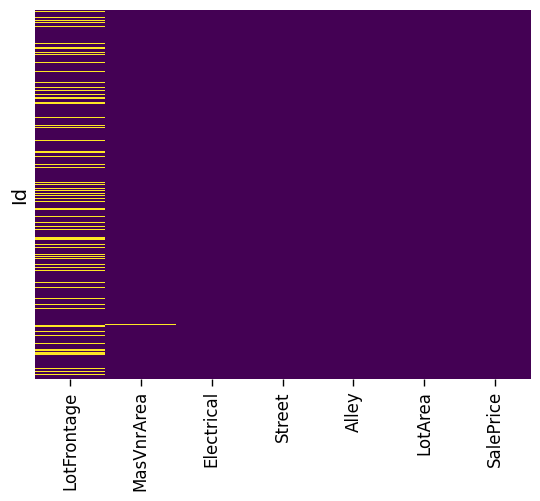

In [9]:
#visualize null values
nulls_train_viz=train[["LotFrontage", "MasVnrArea", "Electrical","Street","Alley", "LotArea","SalePrice"]]

sns.heatmap(nulls_train_viz.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [10]:
# Find datatypes of columns with null values
#Making sure target feature doesn't have nulls

train[["LotFrontage", "MasVnrArea", "Electrical","SalePrice"]].info()


<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LotFrontage  1201 non-null   float64
 1   MasVnrArea   1452 non-null   float64
 2   Electrical   1459 non-null   object 
 3   SalePrice    1460 non-null   int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 57.0+ KB


In [11]:
# Check nulls in test set
nulls_test = test.isnull().sum().to_frame(name='MissingValues_test')
#sorting by descending bc there's too many features
nulls_test.sort_values(by='MissingValues_test', ascending=False, inplace=True)
print(nulls_test.head(20))

#'LotFrontage', 'MasVnrArea', 'MSZoning', 'BsmtHalfBath', 'Functional', 'BsmtFullBath', 'Utilities', 'Exterior1st', 'Exterior2nd', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 
# 'SaleType', 'KitchenQual', 'GarageArea', 'BsmtFinSF1', 'BsmtFinSF2',  'GarageYrBlt' all have missing values we will impute

              MissingValues_test
LotFrontage                  227
GarageYrBlt                   78
MasVnrArea                    15
MSZoning                       4
BsmtHalfBath                   2
BsmtFullBath                   2
Utilities                      2
Functional                     2
Exterior1st                    1
TotalBsmtSF                    1
Exterior2nd                    1
GarageCars                     1
GarageArea                     1
SaleType                       1
KitchenQual                    1
BsmtFinSF1                     1
BsmtUnfSF                      1
BsmtFinSF2                     1
Neighborhood                   0
BldgType                       0


<Axes: ylabel='Id'>

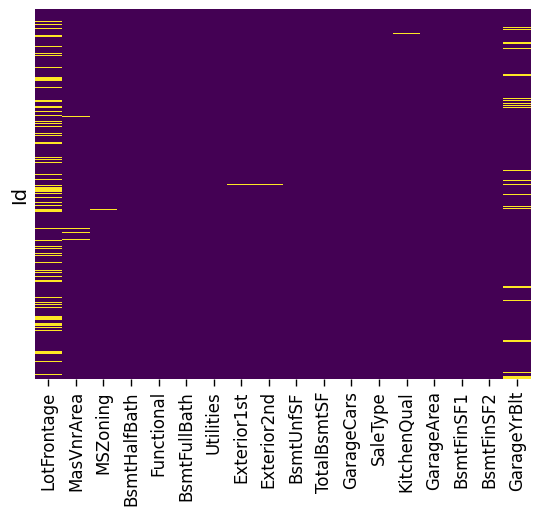

In [12]:
#visualize null values
nulls_test_viz=test[['LotFrontage', 'MasVnrArea', 'MSZoning', 'BsmtHalfBath', 'Functional', 'BsmtFullBath', 'Utilities', 'Exterior1st', 'Exterior2nd', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'SaleType', 'KitchenQual', 'GarageArea', 'BsmtFinSF1', 'BsmtFinSF2', 'GarageYrBlt']]

sns.heatmap(nulls_test_viz.isnull(), yticklabels=False, cbar=False, cmap='viridis')


In [13]:
# Find datatypes of columns with null values
#Making sure target feature doesn't have nulls

test[['LotFrontage', 'MasVnrArea', 'MSZoning', 'BsmtHalfBath', 'Functional', 'BsmtFullBath', 'Utilities', 'Exterior1st', 'Exterior2nd', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'SaleType', 'KitchenQual', 'GarageArea', 'BsmtFinSF1', 'BsmtFinSF2']].info()


<class 'pandas.core.frame.DataFrame'>
Index: 1459 entries, 1461 to 2919
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1232 non-null   float64
 1   MasVnrArea    1444 non-null   float64
 2   MSZoning      1455 non-null   object 
 3   BsmtHalfBath  1457 non-null   float64
 4   Functional    1457 non-null   object 
 5   BsmtFullBath  1457 non-null   float64
 6   Utilities     1457 non-null   object 
 7   Exterior1st   1458 non-null   object 
 8   Exterior2nd   1458 non-null   object 
 9   BsmtUnfSF     1458 non-null   float64
 10  TotalBsmtSF   1458 non-null   float64
 11  GarageCars    1458 non-null   float64
 12  SaleType      1458 non-null   object 
 13  KitchenQual   1458 non-null   object 
 14  GarageArea    1458 non-null   float64
 15  BsmtFinSF1    1458 non-null   float64
 16  BsmtFinSF2    1458 non-null   float64
dtypes: float64(10), object(7)
memory usage: 205.2+ KB


In [14]:
#long code so will define a new one
num_col = ['LotFrontage', 'MasVnrArea', 'BsmtHalfBath', 'BsmtFullBath', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageCars', 'GarageArea',  'GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2']
cat_col = ['MSZoning','Functional','Utilities','Exterior1st','Exterior2nd','SaleType','KitchenQual']

#instantiate the imputers 
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')

#fit the imputers
train[num_col] = num_imputer.fit_transform(train[num_col])
test[num_col]=num_imputer.transform(test[num_col])
train[cat_col] = cat_imputer.fit_transform(train[cat_col])
test[cat_col] = cat_imputer.transform(test[cat_col])


In [15]:
#Sanity check on the null values 
print("Train shape:", train.shape)
print("Train nulls:", train.isnull().sum())
print("-"*30)
print("Test shape:", test.shape)
print("Test nulls:", test.isnull().sum())

Train shape: (1460, 80)
Train nulls: MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 80, dtype: int64
------------------------------
Test shape: (1459, 79)
Test nulls: MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 79, dtype: int64


## Exploratory Data Analysis (EDA)

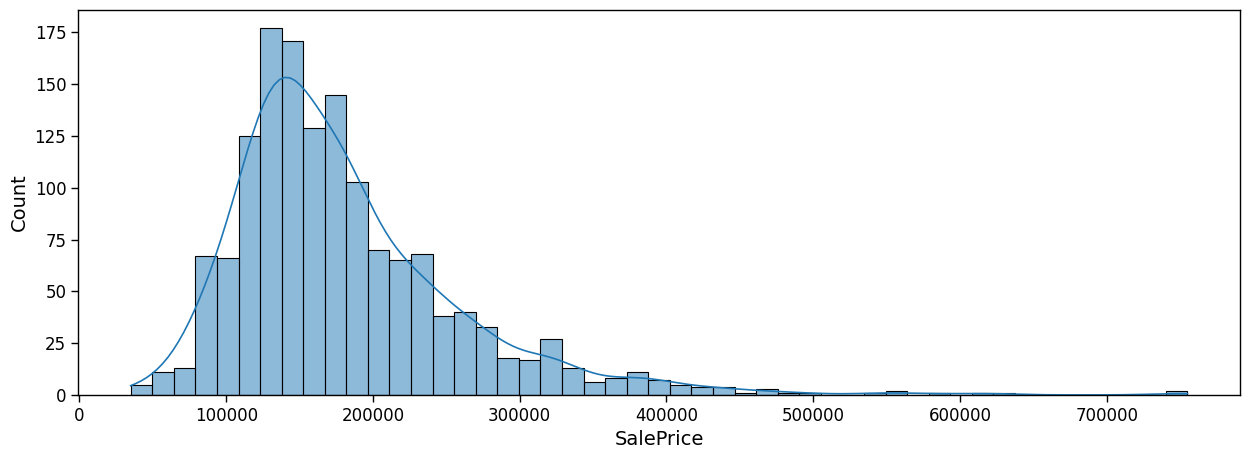

In [16]:
# Histogram to check the distribution of our target variable
plt.figure(figsize=(15, 5))
sns.histplot(data=train, x="SalePrice", kde=True)
plt.show()

In [17]:
# 1) Print the skewness
# 2) print the kurtosis

print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

# a lot of kurtosis because it has a really long tail

Skewness: 1.882876
Kurtosis: 6.536282


##### Independent variables: check the statistical properties of the numerical features 

In [18]:
# Get the statistical properties of the numerical features

train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,69.863699,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,46.549315,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,22.027677,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,161.319273,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,0.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


##### Correlation heatmap 

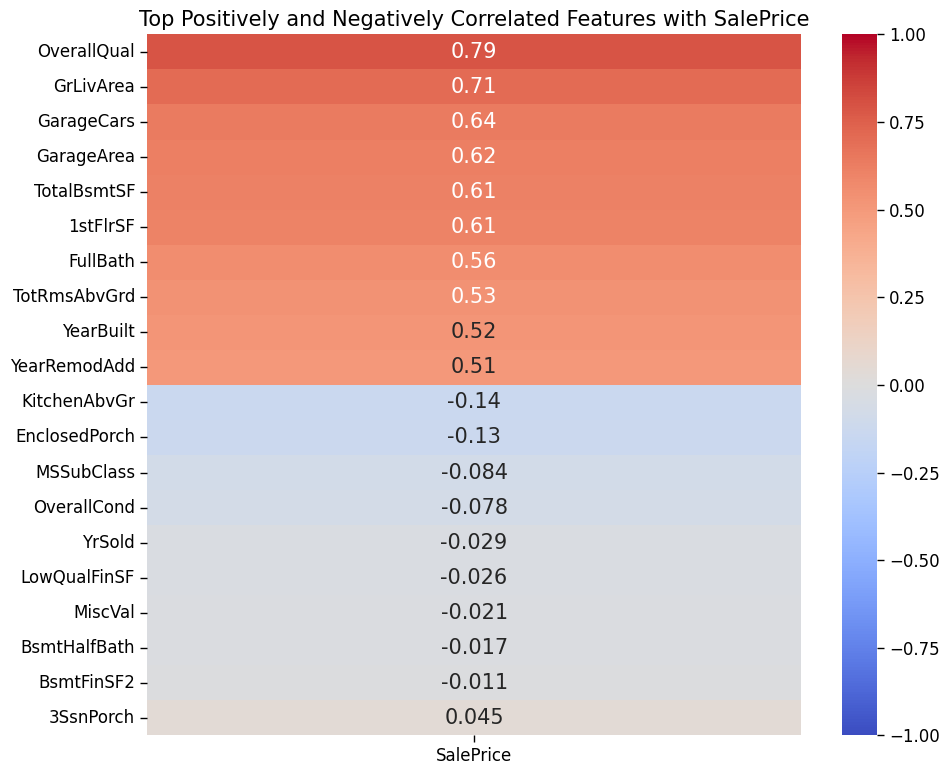

In [19]:
# Get correlation matrix
corr_matrix = train.corr(numeric_only=True)

# Correlation with SalePrice
corr_target = corr_matrix['SalePrice'].drop('SalePrice')

# Get top 10 positively and 10 negatively correlated features
pos_corr = corr_target.sort_values(ascending=False).head(10)
neg_corr = corr_target.sort_values(ascending=True).head(10)
combined_corr = pd.concat([pos_corr, neg_corr])

# Plot as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(combined_corr.to_frame(), annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title("Top Positively and Negatively Correlated Features with SalePrice")
plt.tight_layout()
plt.show()


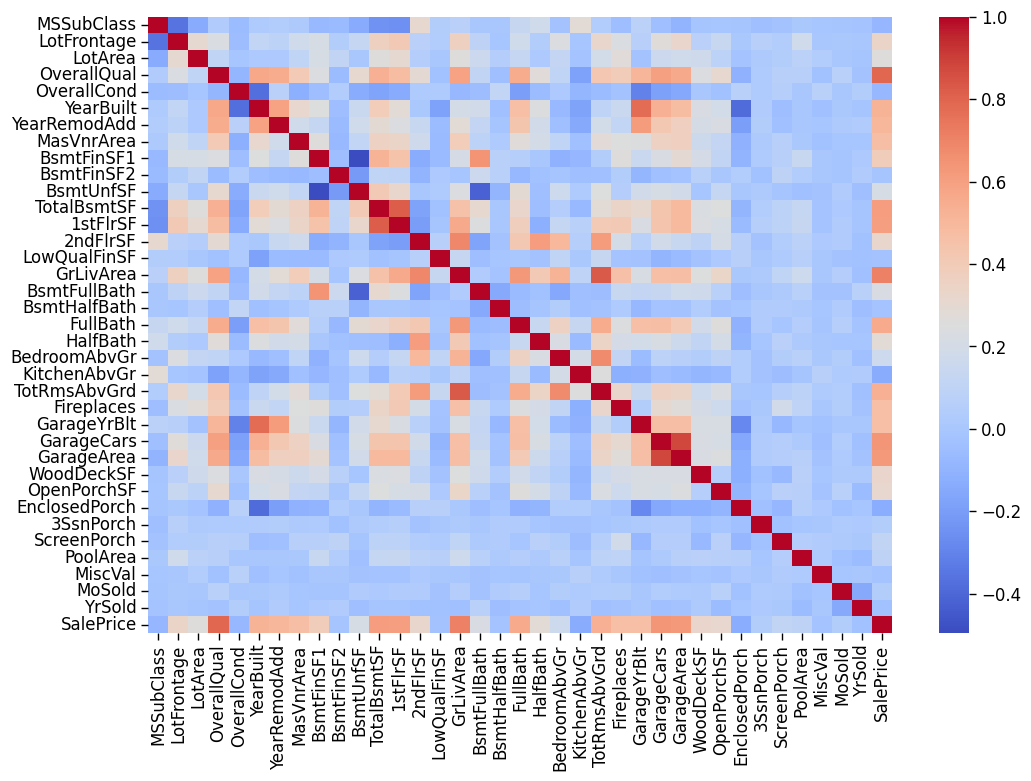

In [20]:
#sns box plot of the features against one another instead of our target variable
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corr_matrix, annot_kws={'size': 8}, cmap="coolwarm", yticklabels=True);

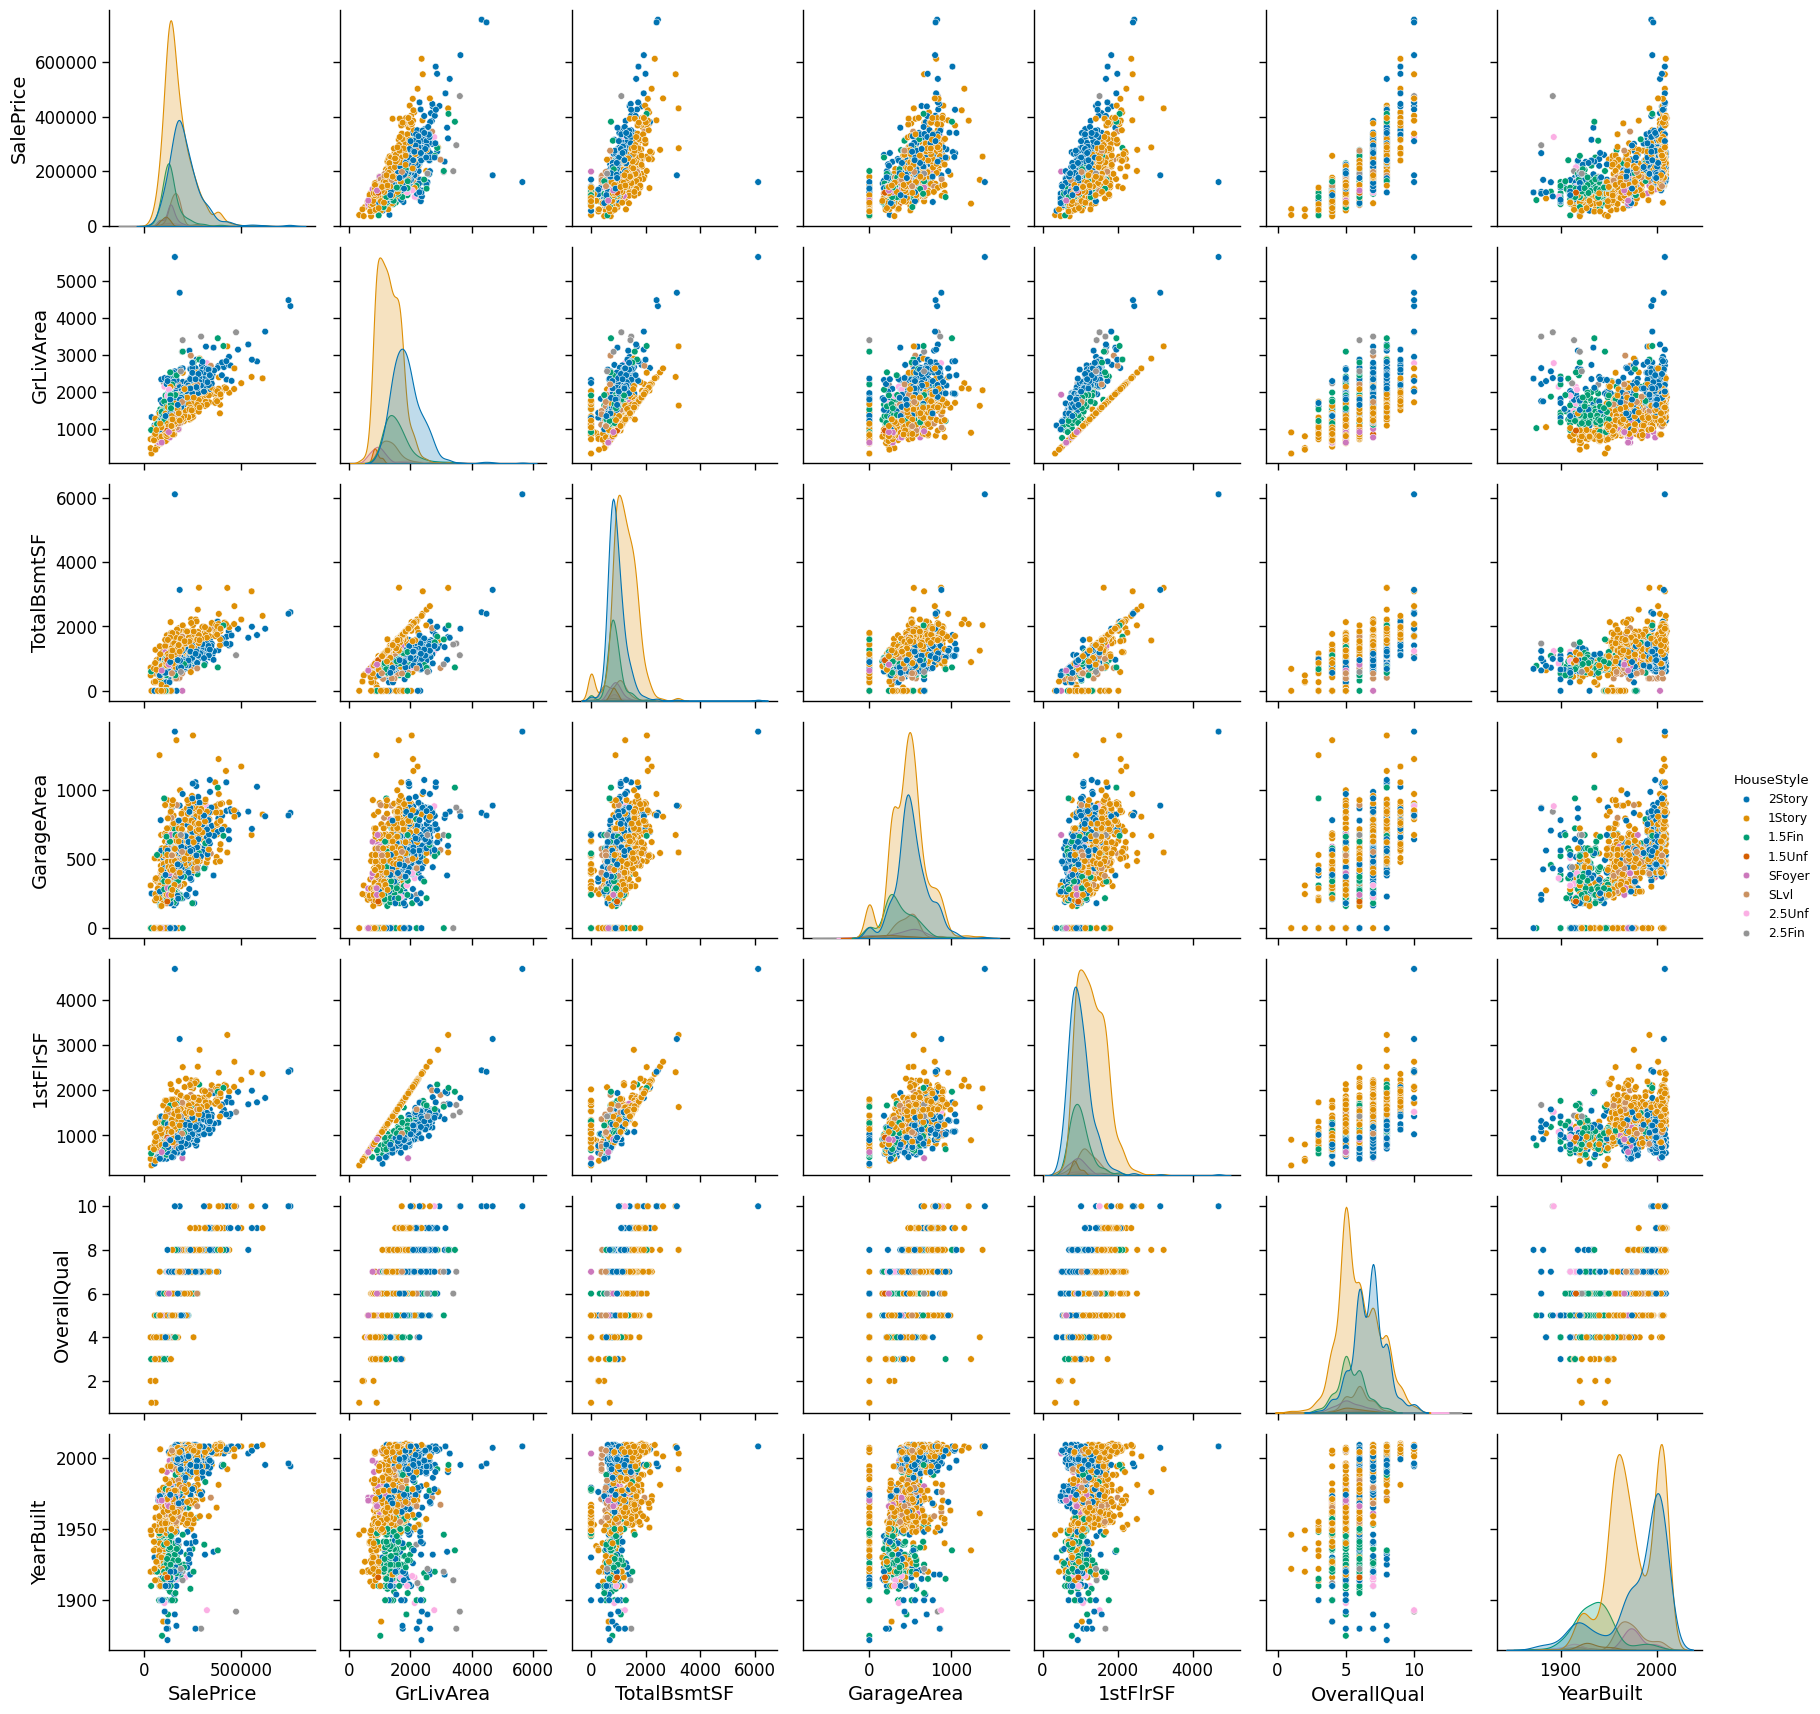

In [21]:
# Select some of the continuous numerical features and HouseStyle as the Hue
features = ['SalePrice', 'GrLivArea', 'TotalBsmtSF', 'GarageArea', '1stFlrSF', 'OverallQual', 'YearBuilt','HouseStyle']

# make a dataframe of those features
con_features = train[features]

# Plot pairplot
sns.pairplot(data=con_features, hue='HouseStyle', palette='colorblind')
plt.show()

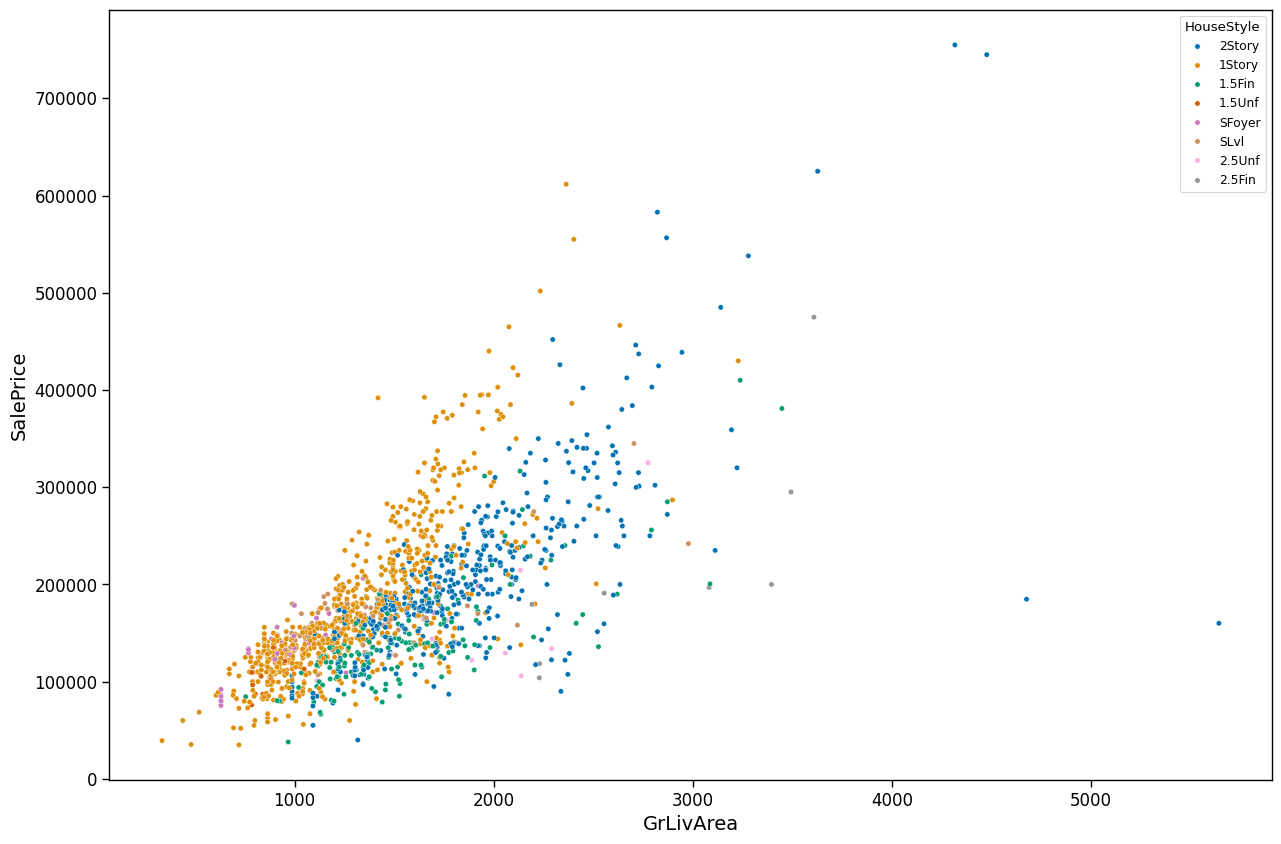

In [22]:
# Plot the relationship between GrLivArea and SalePrice using a 2D scatterplot. Use hue='cut'

plt.figure(figsize=(15, 10))
sns.scatterplot(x='GrLivArea', y='SalePrice', hue="HouseStyle", data=train, palette='colorblind', s=15)
plt.show()

Text(0.5, 1.0, 'Average Sale Price by House Style and Street Type')

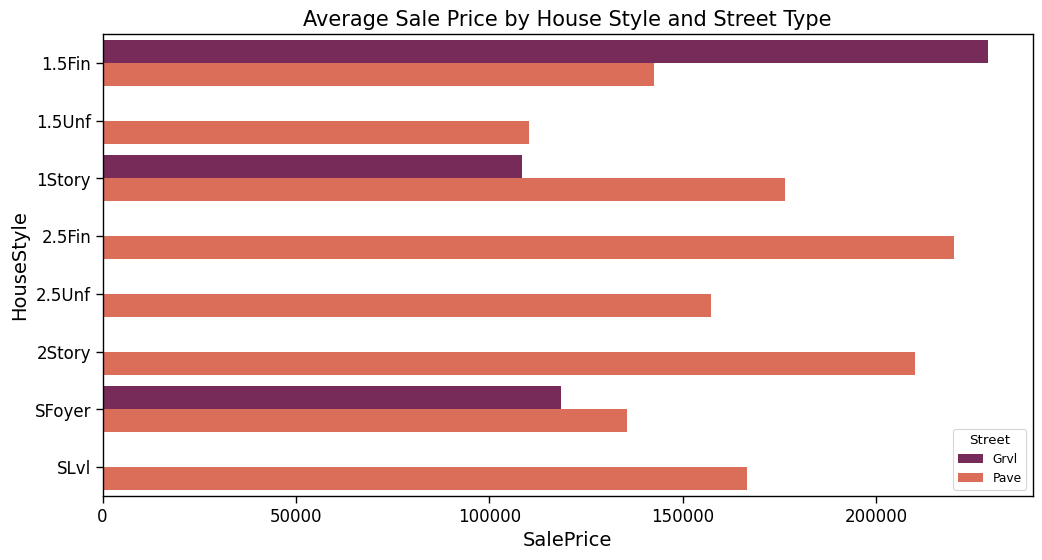

In [23]:
#group by to see average sale price by housestyle and street type

grouped_col = train.groupby(['HouseStyle', 'Street'])['SalePrice'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=grouped_col, x='SalePrice', y='HouseStyle', hue='Street', palette='rocket')
plt.title("Average Sale Price by House Style and Street Type")


## Feature Engineering and Creation

Due to the pleathora of features, many are repetitive and can be combined and perhaps will become more useful. The following new features will be created based on highly correlated features:

1. TotalSF = TotalBsmtSF + 1stFlrSF + 2ndFlrSF (numerical, continuous)
2. TotalBathrooms = Combination of FullBath, HalfBAth, BsmtFullBath and BsmtHalfBath (numerical, float)
3. Remodel = When YearBuilt does not equal YearRemodAdd (binary)
4. GSpaceperCar = GarageArea / GarageCars to determine actual space per car (numerical, continuous)
5. RemodelAge = YearRemodAdd - YearBuilt

Because many of these features are highly correlated to SalePrice on their own, we won't drop all of them initially. 

In [24]:
# 1. TotalSF = TotalBsmtSF + 1stFlrSF + 2ndFlrSF
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

# 2. TotalBathrooms = FullBath + (0.5 * HalfBath) + BsmtFullBath + (0.5 * BsmtHalfBath)
train['TotalBathrooms'] = (
    train['FullBath'] + (0.5 * train['HalfBath']) + 
    train['BsmtFullBath'] + (0.5 * train['BsmtHalfBath'])
)
test['TotalBathrooms'] = (
    test['FullBath'] + (0.5 * test['HalfBath']) + 
    test['BsmtFullBath'] + (0.5 * test['BsmtHalfBath'])
)

# 3. Remodel = When YearBuilt != YearRemodAdd
train['Remodeled'] = (train['YearBuilt'] != train['YearRemodAdd']).astype(int)
test['Remodeled'] = (test['YearBuilt'] != test['YearRemodAdd']).astype(int)

# 4. GSpaceperCar = GarageArea / GarageCars (with handling for zero cars)
train['GSpaceperCar'] = (train['GarageArea'] / train['GarageCars'] +1)
test['GSpaceperCar'] = (test['GarageArea'] / test['GarageCars'] +1 )

#5. RemodelAge = YearRemodAdd-YearBuilt (added later because remodel binary was not highly correlated)
train['RemodelAge'] = (train['YearRemodAdd'] - train['YearBuilt'])
test['RemodelAge'] = (test['YearRemodAdd'] / test['YearBuilt'])

Now that the new features are created, I want to visualize their correlation and plot them to see if they are useful

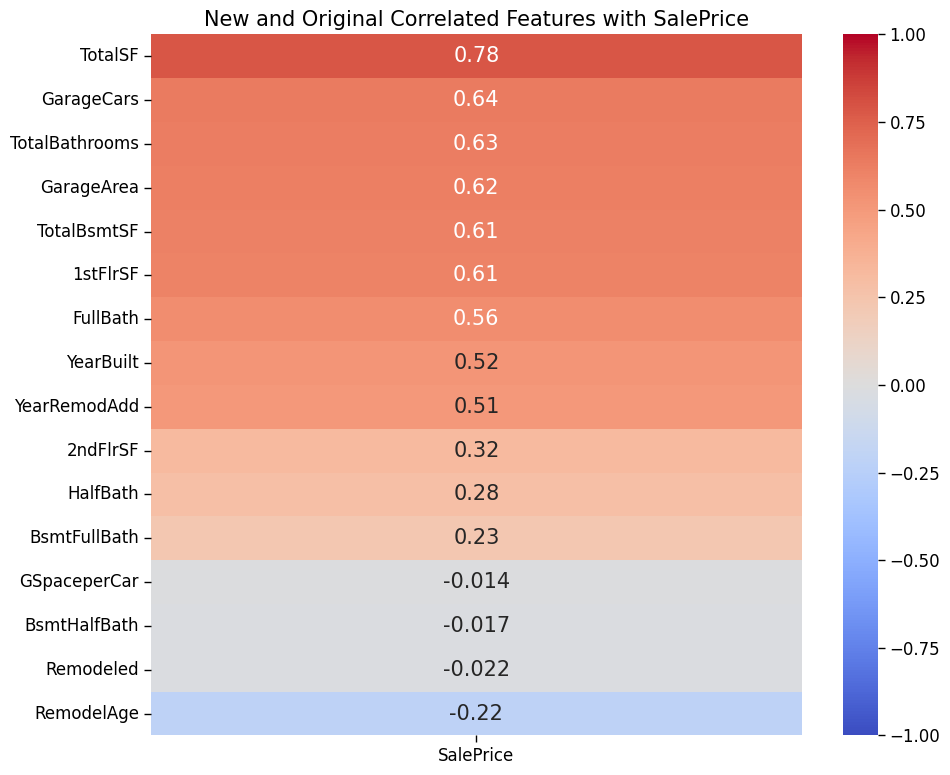

In [25]:
#create a DF using the new features and their components to compare correlation w target feature
newfeatures = train[['SalePrice','TotalSF','TotalBsmtSF','1stFlrSF','2ndFlrSF','TotalBathrooms','FullBath', 'HalfBath',
                    'BsmtFullBath','BsmtHalfBath','Remodeled', 'RemodelAge','YearBuilt','YearRemodAdd','GSpaceperCar','GarageArea','GarageCars']]

# Get correlation matrix
new_corr_matrix = newfeatures.corr(numeric_only=True)

# Correlation with SalePrice
new_corr_target = new_corr_matrix['SalePrice'].drop('SalePrice').sort_values(ascending=False)

# Plot as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(new_corr_target.to_frame(), annot=True, cmap='coolwarm',vmin=-1, vmax=1)
plt.title("New and Original Correlated Features with SalePrice")
plt.tight_layout()
plt.show()



There are too many features to encode. Let's drop the features that are between -0.29 and 0.29. At least the numerical ones before encoding. 

In [26]:
#Drop unecessary features

# Get correlation matrix
final_corr_matrix = train.corr(numeric_only=True)

# Correlation with SalePrice
final_corr_target = final_corr_matrix['SalePrice'].drop('SalePrice')

drop_col = final_corr_target[(final_corr_target > -0.29) & (final_corr_target < 0.29)].index.tolist()

print("Columns to drop:", drop_col)

Columns to drop: ['MSSubClass', 'LotArea', 'OverallCond', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'Remodeled', 'GSpaceperCar', 'RemodelAge']


In [27]:
#drop the columns 
train.drop(columns=drop_col, inplace=True)
test.drop(columns=drop_col, inplace=True)

#sanity check
print(train.shape)
print(test.shape)

(1460, 64)
(1459, 63)


## Encoding and Scaling

Due to the combination of categorical and ordinal features, we will use a combination of OHE and ordinal encoding

In [30]:
# Define ordinal mappings
qual_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
exposure_map = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
finish_map = {'Unf': 1, 'RFn': 2, 'Fin': 3}
fence_map = {'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}
slope_map = {'Sev': 1, 'Mod': 2, 'Gtl': 3}
lotshape_map = {'IR3': 1, 'IR2': 2, 'IR1': 3, 'Reg': 4}
paved_map = {'N': 1, 'P': 2, 'Y': 3}
util_map = {'ELO': 1, 'NoSeWa': 2, 'NoSewr': 3, 'AllPub': 4}
func_map = {'Sal': 1, 'Sev': 2, 'Maj2': 3, 'Maj1': 4, 'Mod': 5, 'Min2': 6, 'Min1': 7, 'Typ': 8}

# Dictionary to map the column names to their variables
ordinal_features = {
    'ExterQual': qual_map,
    'ExterCond': qual_map,
    'BsmtQual': qual_map,
    'BsmtCond': qual_map,
    'HeatingQC': qual_map,
    'KitchenQual': qual_map,
    'FireplaceQu': qual_map,
    'GarageQual': qual_map,
    'GarageCond': qual_map,
    'PoolQC': qual_map,
    'BsmtExposure': exposure_map,
    'GarageFinish': finish_map,
    'Fence': fence_map,
    'LandSlope': slope_map,
    'LotShape': lotshape_map,
    'PavedDrive': paved_map,
    'Utilities': util_map,
    'Functional': func_map
}

# Apply mappings
for col, mapkey in ordinal_features.items():
    if col in train.columns:
        train[col] = train[col].map(mapkey)

# ------------------------------
# ONE-HOT ENCODING
# ------------------------------

# Identify object-type (nominal) columns not in ordinal list
nominal_cols = train.select_dtypes(include='object').columns.difference(ordinal_features.keys())

# One-hot encode those columns (drop_first avoids multicollinearity)
train = pd.get_dummies(train, columns=nominal_cols, drop_first=True)

# Sanity check
print("Train shape:", train.shape)
train.head()


Train shape: (1460, 197)


,LotFrontage,LotShape,Utilities,LandSlope,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,...,SaleCondition_Partial,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Pave
Id,,,,,,,,,,,,,,,,,,,,,
1,65.0,4,4,3,7,2003,2003,196.0,4,3,...,False,False,False,False,False,False,False,False,True,True
2,80.0,4,4,3,6,1976,1976,0.0,3,3,...,False,False,False,False,False,False,False,False,True,True
3,68.0,3,4,3,7,2001,2002,162.0,4,3,...,False,False,False,False,False,False,False,False,True,True
4,60.0,3,4,3,7,1915,1970,0.0,3,3,...,False,False,False,False,False,False,False,False,True,True
5,84.0,3,4,3,8,2000,2000,350.0,4,3,...,False,False,False,False,False,False,False,False,True,True


In [ ]:
# One-hot encoding
train_encoded = pd.get_dummies(train, drop_first=True)
test_encoded = pd.get_dummies(test, drop_first=True)

# Align columns
X = train_encoded.drop(columns=['SalePrice', 'Id'])
y = train_encoded['SalePrice']
X_test = test_encoded.reindex(columns=X.columns, fill_value=0)

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

In [ ]:
#check on features scale against one another 

plt.figure(figsize=(15,5))
ax = sns.boxplot(data=train)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
plt.show();

## Step 6: Feature Importance

In [ ]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_scaled_df, y)
importances = pd.Series(rf.feature_importances_, index=X.columns)
top_features = importances.sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_features.values, y=top_features.index)
plt.title('Top 20 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

## Step 7: Modeling and Evaluation

In [ ]:
# Define models
from sklearn.pipeline import Pipeline
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.01),
    'Polynomial Regression (deg 2)': Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('linreg', LinearRegression())])
}

# Use top features for poly regression
X_poly = X_scaled_df[top_features.index]
results = []

for name, model in models.items():
    if 'Polynomial' in name:
        model.fit(X_poly, y)
        y_pred = model.predict(X_poly)
    else:
        model.fit(X_scaled_df, y)
        y_pred = model.predict(X_scaled_df)
    
    rmse = mean_squared_error(y, y_pred, squared=False)
    r2 = r2_score(y, y_pred)
    y_bin = pd.qcut(y, q=4, labels=False)
    y_pred_bin = pd.qcut(pd.Series(y_pred).rank(method='first'), q=4, labels=False)
    f1 = f1_score(y_bin, y_pred_bin, average='macro')
    results.append({'Model': name, 'Train RMSE': round(rmse, 2), 'Train R²': round(r2, 3), 'F1 Score': round(f1, 3)})

pd.DataFrame(results).sort_values(by='Train RMSE')